# Super-resolution of WBPT using Gaussian random fields

In [ ]:
from azureml.core import Workspace, Datastore, Dataset

from downscaling_utils import *

from matplotlib import pyplot as plt

In [2]:
# !conda install -n azureml_py36 -c conda-forge iris -y

In [3]:
# !pip install gpy

In [4]:
# !pip install azureml-sdk[notebooks]

## Mount Azure data

In [5]:
ws = Workspace.from_config()
dset = ws.datasets['mogreps_uk']

In [6]:
# !sudo umount "/mnt/batch/tasks/shared/LS_root/mounts/clusters/rpgp8/code/users/rachel/paper1/gp-downscaling/mogreps-uk"

In [7]:
# !fusermount -uz mogreps-uk

In [8]:
mnt = dset.mount('mogreps-uk')
mnt.start()

In [23]:
mnt.stop()

In [10]:
def list_mogreps_uk(folder, years, months, days, hours, fcsts):
    fs = ['prods_op_mogreps-uk_{:04d}{:02d}{:02d}_{:02d}_00_{:03d}.nc'.format(year, month, day, hour, fcst)
            for year in years for month in months for day in days for hour in hours for fcst in fcsts]
    fs = [os.path.join(folder,f) for f in fs]
    return fs

In [11]:
fs = list_mogreps_uk(mnt.mount_point, 
                     [2016], 
                     list(range(1,13)),
#                      [1,2],
                     [5, 15, 25],
                     [15],
                     [3])

In [12]:
# iris.load(fs[1])

## Start local Dask cluster

In [13]:
import dask
import distributed
from dask import bag
from dask import delayed

In [14]:
client = distributed.Client()

 /anaconda/envs/azureml_py36/lib/python3.6/site-packages/distributed/node.py:155: UserWarning:Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35573 instead


In [15]:
client

Client Scheduler: tcp://127.0.0.1:34507 Dashboard: http://127.0.0.1:35573/status,Cluster Workers: 4 Cores: 8 Memory: 29.50 GB


## Super-resolution experiment

In [16]:
sdim = 48

In [17]:
a2s = {}
for n in [4, 8]:
    a2s[n] = compute_cov_block(n, sdim)

In [18]:
def get_samples(fname, a2s, la):
    a2 = a2s[la]
    
    f_orig = iris.load(fname, 'wet_bulb_potential_temperature')[0][0,2,-420:-372,-120:-72].data
    f_orig = (f_orig - np.mean(f_orig))
    f = np.dot(a2, f_orig.flatten()).reshape(int(np.sqrt(a2.shape[0])), -1)
    f = f * 100

    l = sp.optimize.minimize_scalar(lambda l: negloglik(l, f_orig.shape[0], a2, f, v=1),
                                        method='Bounded', bounds=(0.1, 15), tol=0.1).x
    
    mu_p, C_p, cp2 = condition(f, l, a2, sdim)
    
    samples = [mu_p + np.real(np.dot(cp2, np.random.normal(size=mu_p.shape[0]))) for _ in range(20)]#(50)]
    
    b = bicub(f, la, sdim).flatten()
    
    if f.shape[0] != f_orig.shape[0]:
        f = expand(f, f_orig.shape[0]//f.shape[0])
    
    return {'mean': mu_p/100, 
            'samples': [s/100 for s in samples], 
            'cov': C_p/100,
            'orig_lr': f.flatten()/100, 
            'bicub': b/100, 
            'orig_hr': f_orig.flatten(),
            'l': l}

In [19]:
%%time
samples = {}
for n in [4, 8]:
    samples[n] = bag.zip(bag.from_sequence(fs),
                         bag.from_sequence([n for _ in fs])).map(lambda i: get_samples(i[0], a2s, i[1])).persist()

CPU times: user 824 ms, sys: 329 ms, total: 1.15 s
Wall time: 1.06 s


In [20]:
mses = {}
psds = {}
ws4 = {}
ws8 = {}
ws16 = {}
for n in [4,8]:
    mses[n] = samples[n].map(lambda s: get_mse(s)).persist()
    psds[n] = samples[n].map(lambda s: get_psd_mse(s, sdim)).persist()
    ws4[n] = samples[n].map(lambda s: get_spatial_wass_4(s, sdim)).persist()
    ws8[n] = samples[n].map(lambda s: get_spatial_wass_8(s, sdim)).persist()

In [21]:
%%time
s = samples[8].compute()

CPU times: user 18.1 s, sys: 4.18 s, total: 22.3 s
Wall time: 5min 22s


In [22]:
%%time
s4 = samples[4].compute()

CPU times: user 268 ms, sys: 2.09 s, total: 2.36 s
Wall time: 2.35 s


## Results

In [24]:
print("MSE 4")
print({i: np.mean([r[i] for r in mses[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("PSD 4")
print({i: np.mean([r[i] for r in psds[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W4 4")
print({i: np.mean([r[i] for r in ws4[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W8 4")
print({i: np.mean([r[i] for r in ws8[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

MSE 4
{'mean': 0.003467026574995764, 'orig_lr': 0.006442599826388889, 'bicub': 0.004478473271545564, 'GRF': 0.006132966001915391}
PSD 4
{'mean': 0.8799144241048662, 'orig_lr': 0.5631433257419931, 'bicub': 0.8933645594483024, 'GRF': 0.4316593947391427}
W4 4
{'mean': 0.025714414508202197, 'orig_lr': 0.025377025265278807, 'bicub': 0.027795180606092696, 'GRF': 0.027059492910860475}
W8 4
{'mean': 0.022110148676459246, 'orig_lr': 0.02182005052754259, 'bicub': 0.023899264486392867, 'GRF': 0.023266693314353493}


In [25]:
print("MSE 4")
print({i: np.mean([r[i] for r in mses[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("PSD 4")
print({i: np.mean([r[i] for r in psds[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W4 4")
print({i: np.mean([r[i] for r in ws4[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W8 4")
print({i: np.mean([r[i] for r in ws8[4]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

MSE 4
{'mean': 0.003467026574995764, 'orig_lr': 0.006442599826388889, 'bicub': 0.004478473271545564, 'GRF': 0.006132966001915391}
PSD 4
{'mean': 0.8799144241048662, 'orig_lr': 0.5631433257419931, 'bicub': 0.8933645594483024, 'GRF': 0.4316593947391427}
W4 4
{'mean': 0.025714414508202197, 'orig_lr': 0.025377025265278807, 'bicub': 0.027795180606092696, 'GRF': 0.027059492910860475}
W8 4
{'mean': 0.022110148676459246, 'orig_lr': 0.02182005052754259, 'bicub': 0.023899264486392867, 'GRF': 0.023266693314353493}


In [26]:
print("MSE 8")
print({i: np.mean([r[i] for r in mses[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("PSD 8")
print({i: np.mean([r[i] for r in psds[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W4 8")
print({i: np.mean([r[i] for r in ws4[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W8 8")
print({i: np.mean([r[i] for r in ws8[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

MSE 8
{'mean': 0.0114446398183858, 'orig_lr': 0.01648066742251618, 'bicub': 0.011417879257480721, 'GRF': 0.01704695457115502}
PSD 8
{'mean': 1.4777748040687693, 'orig_lr': 1.1407534144194122, 'bicub': 1.4145173201565173, 'GRF': 0.9218185241168189}
W4 8
{'mean': 0.031985914224503136, 'orig_lr': 0.03817818468314593, 'bicub': 0.0377820302627923, 'GRF': 0.03129196011207224}
W8 8
{'mean': 0.027502602338549977, 'orig_lr': 0.03282693221854996, 'bicub': 0.03248630533252033, 'GRF': 0.026905915824745472}


In [27]:
print("MSE 8")
print({i: np.mean([r[i] for r in mses[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("PSD 8")
print({i: np.mean([r[i] for r in psds[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W4 8")
print({i: np.mean([r[i] for r in ws4[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

print("W8 8")
print({i: np.mean([r[i] for r in ws8[8]]) for i in ['mean', 'orig_lr', 'bicub', 'GRF']})

MSE 8
{'mean': 0.0114446398183858, 'orig_lr': 0.01648066742251618, 'bicub': 0.011417879257480721, 'GRF': 0.01704695457115502}
PSD 8
{'mean': 1.4777748040687693, 'orig_lr': 1.1407534144194122, 'bicub': 1.4145173201565173, 'GRF': 0.9218185241168189}
W4 8
{'mean': 0.031985914224503136, 'orig_lr': 0.03817818468314593, 'bicub': 0.0377820302627923, 'GRF': 0.03129196011207224}
W8 8
{'mean': 0.027502602338549977, 'orig_lr': 0.03282693221854996, 'bicub': 0.03248630533252033, 'GRF': 0.026905915824745472}


## Visualising output

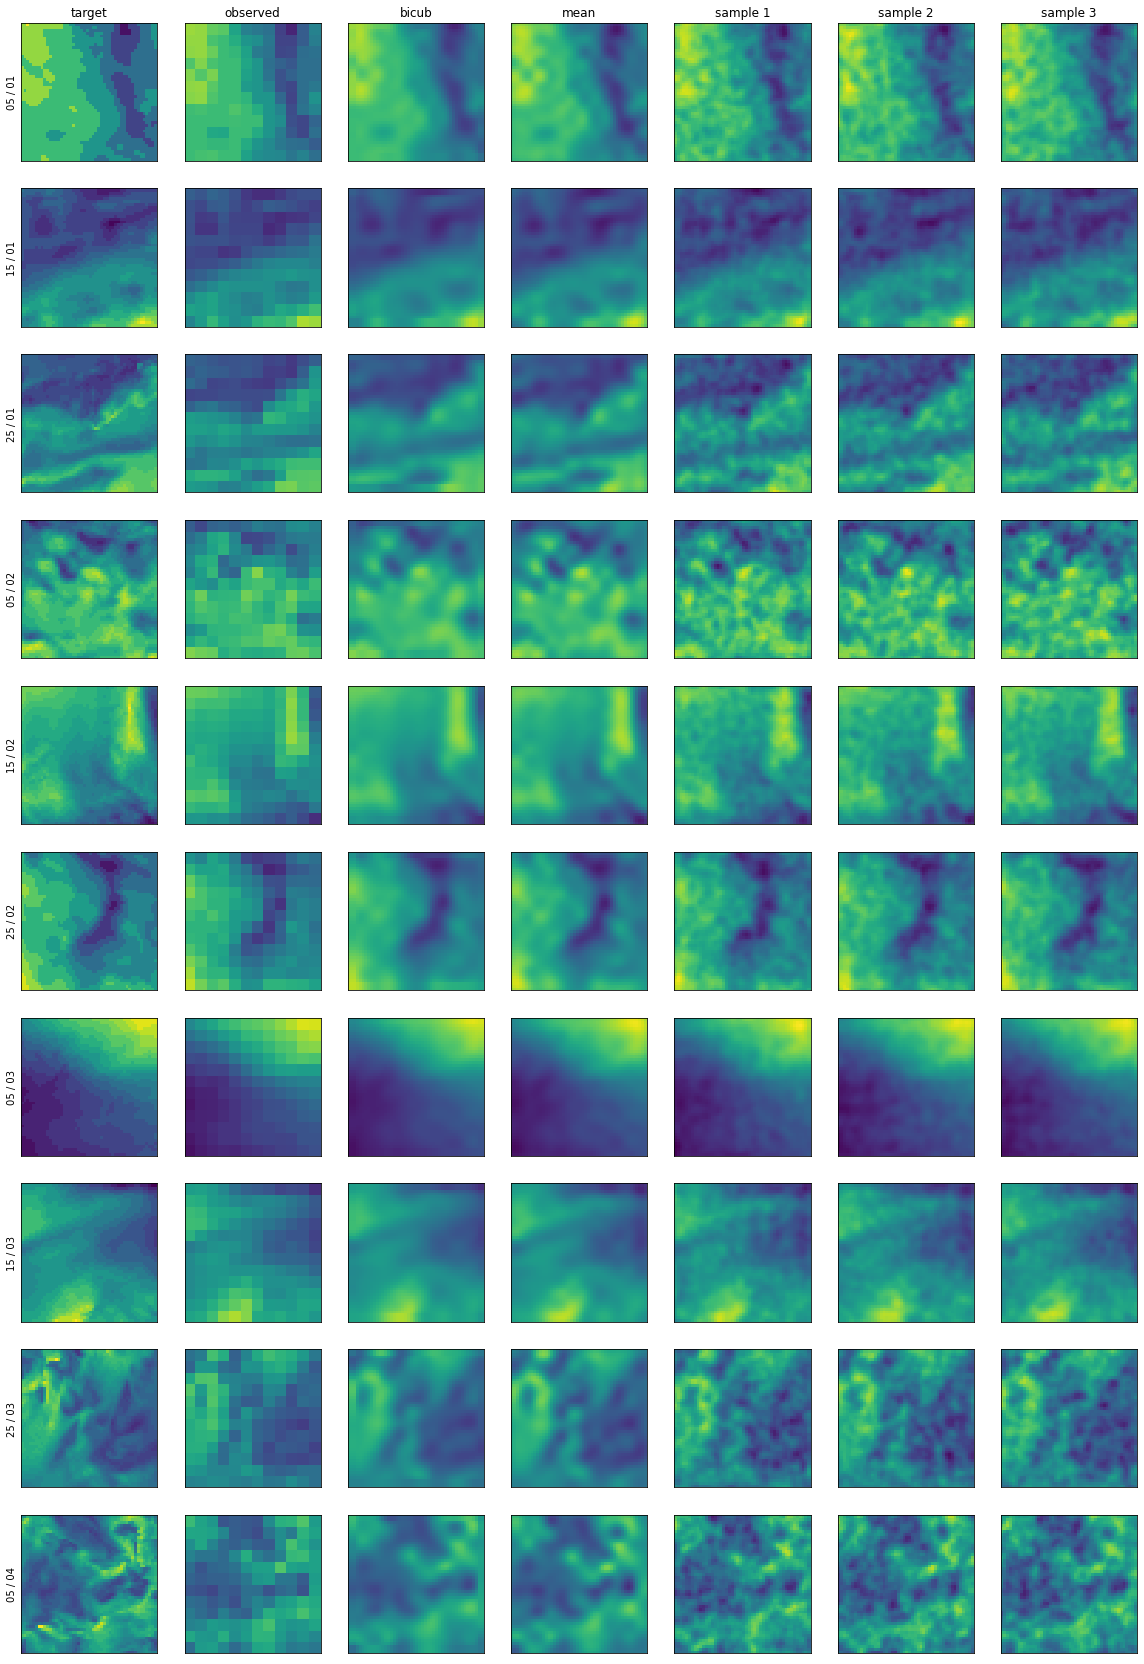

In [100]:
s4 = samples[4].compute()
fig, axes = plt.subplots(10, 7, figsize=(20,3*10))
for i in range(10):
    s = s4[i+8]
    all_vals = np.concatenate([s['orig_hr'][np.newaxis,:], 
                               s['orig_lr'][np.newaxis,:], 
                               s['bicub'][np.newaxis,:],
                               s['mean'][np.newaxis,:], 
                               s['samples']])
    low = all_vals.min()
    high = all_vals.max()

    axes[i,0].pcolormesh(s['orig_hr'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,1].pcolormesh(s['orig_lr'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,2].pcolormesh(s['bicub'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,3].pcolormesh(s['mean'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,4].pcolormesh(s['samples'][0].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,5].pcolormesh(s['samples'][1].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,6].pcolormesh(s['samples'][2].reshape((sdim,sdim)), vmin=low, vmax=high);
    
    axes[i,0].get_xaxis().set_visible(False); axes[i,0].get_yaxis().set_visible(True);
    axes[i,1].get_xaxis().set_visible(False); axes[i,1].get_yaxis().set_visible(False);
    axes[i,2].get_xaxis().set_visible(False); axes[i,2].get_yaxis().set_visible(False);
    axes[i,3].get_xaxis().set_visible(False); axes[i,3].get_yaxis().set_visible(False);
    axes[i,4].get_xaxis().set_visible(False); axes[i,4].get_yaxis().set_visible(False);
    axes[i,5].get_xaxis().set_visible(False); axes[i,5].get_yaxis().set_visible(False);
    axes[i,6].get_xaxis().set_visible(False); axes[i,6].get_yaxis().set_visible(False);
    
    axes[i,0].axes.get_yaxis().set_ticks([])
    axes[i,0].set_ylabel(fs[i].split('/')[-1][26:28] + ' / ' + fs[i].split('/')[-1][24:26])
    

axes[0,0].set_title('target');
axes[0,1].set_title('observed');
axes[0,2].set_title('bicub');
axes[0,3].set_title('mean');
axes[0,4].set_title('sample 1');
axes[0,5].set_title('sample 2');
axes[0,6].set_title('sample 3');

plt.show()

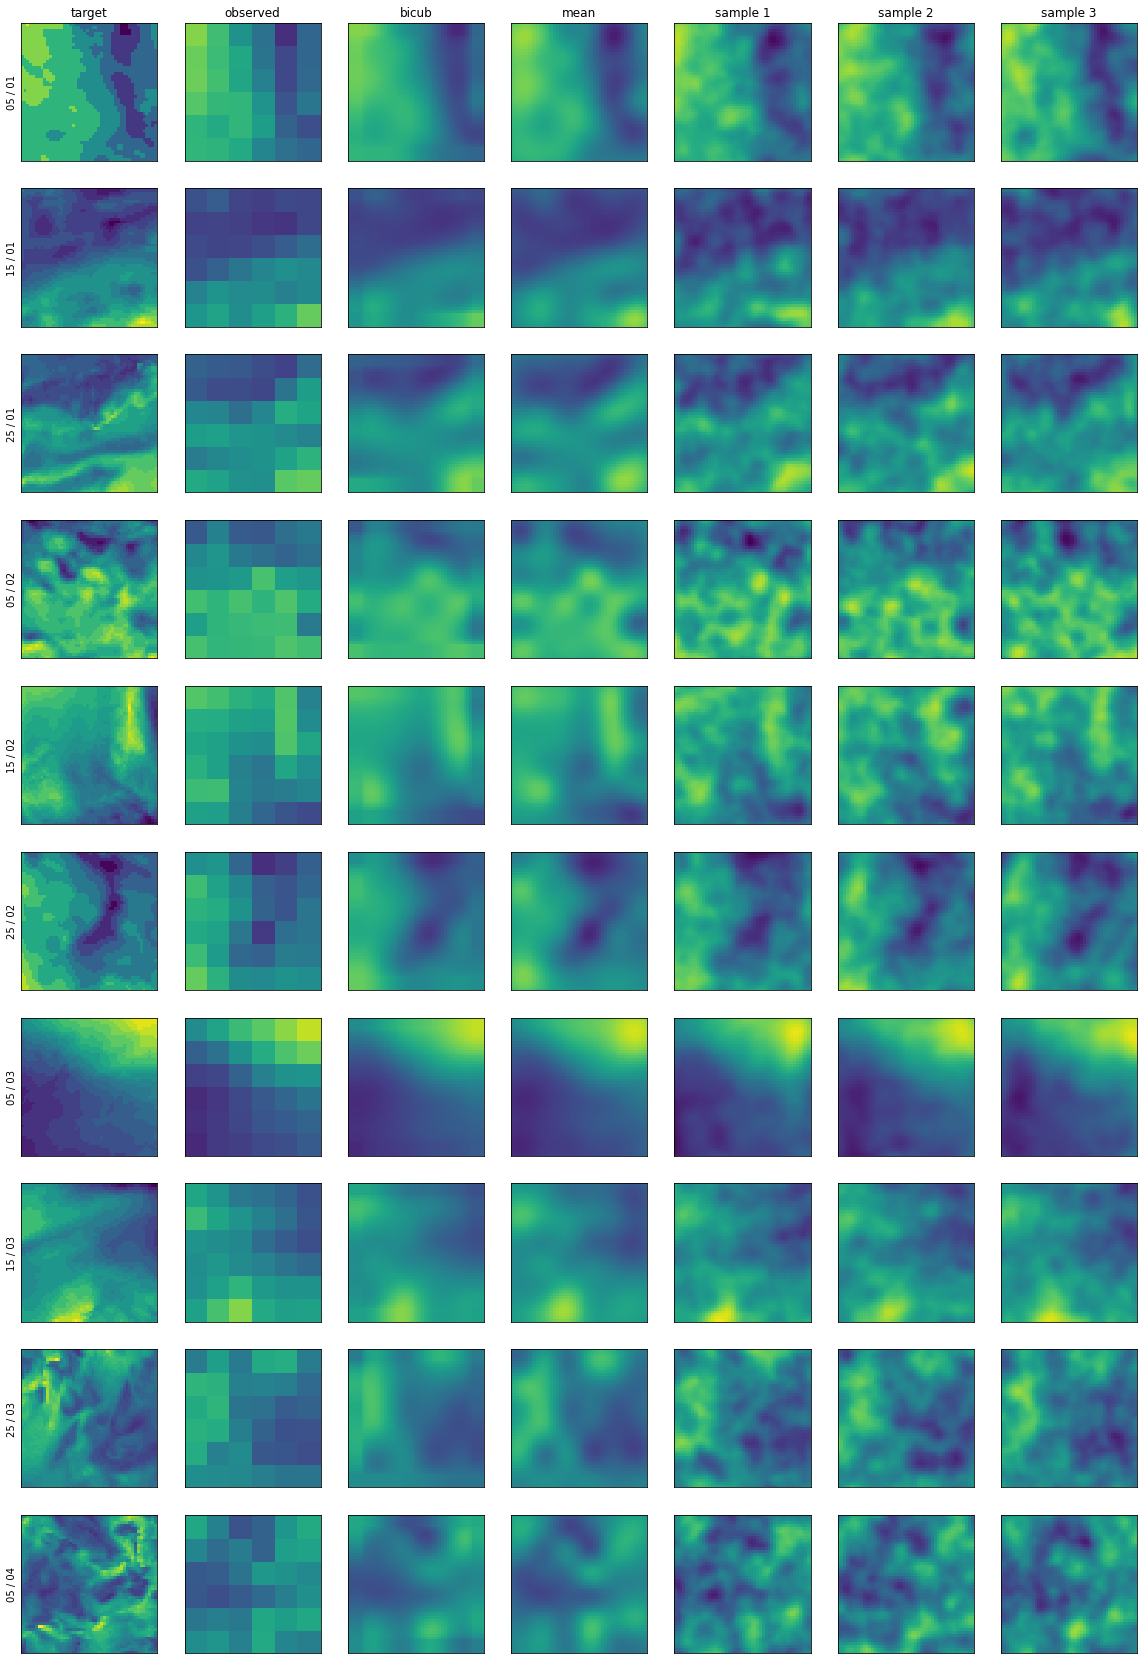

In [101]:
s8 = samples[8].compute()
fig, axes = plt.subplots(10, 7, figsize=(20,3*10))
for i in range(10):
    s = s8[i+8]
    all_vals = np.concatenate([s['orig_hr'][np.newaxis,:], 
                               s['orig_lr'][np.newaxis,:], 
                               s['bicub'][np.newaxis,:],
                               s['mean'][np.newaxis,:], 
                               s['samples']])
    low = all_vals.min()
    high = all_vals.max()

    axes[i,0].pcolormesh(s['orig_hr'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,1].pcolormesh(s['orig_lr'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,2].pcolormesh(s['bicub'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,3].pcolormesh(s['mean'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,4].pcolormesh(s['samples'][0].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,5].pcolormesh(s['samples'][1].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[i,6].pcolormesh(s['samples'][2].reshape((sdim,sdim)), vmin=low, vmax=high);
    
    axes[i,0].get_xaxis().set_visible(False); axes[i,0].get_yaxis().set_visible(True);
    axes[i,1].get_xaxis().set_visible(False); axes[i,1].get_yaxis().set_visible(False);
    axes[i,2].get_xaxis().set_visible(False); axes[i,2].get_yaxis().set_visible(False);
    axes[i,3].get_xaxis().set_visible(False); axes[i,3].get_yaxis().set_visible(False);
    axes[i,4].get_xaxis().set_visible(False); axes[i,4].get_yaxis().set_visible(False);
    axes[i,5].get_xaxis().set_visible(False); axes[i,5].get_yaxis().set_visible(False);
    axes[i,6].get_xaxis().set_visible(False); axes[i,6].get_yaxis().set_visible(False);
    
    axes[i,0].axes.get_yaxis().set_ticks([])
    axes[i,0].set_ylabel(fs[i].split('/')[-1][26:28] + ' / ' + fs[i].split('/')[-1][24:26])
    

axes[0,0].set_title('target');
axes[0,1].set_title('observed');
axes[0,2].set_title('bicub');
axes[0,3].set_title('mean');
axes[0,4].set_title('sample 1');
axes[0,5].set_title('sample 2');
axes[0,6].set_title('sample 3');

plt.show()

## Selected outputs

In [102]:
def show_fig(i, sn):
    fig, axes = plt.subplots(1, 7, figsize=(20,2.5*1))

    s = sn[i]
    all_vals = np.concatenate([s['orig_hr'][np.newaxis,:], 
                               s['orig_lr'][np.newaxis,:], 
                               s['bicub'][np.newaxis,:],
                               s['mean'][np.newaxis,:], 
                               s['samples']])
    low = all_vals.min()
    high = all_vals.max()

    axes[0].pcolormesh(s['orig_hr'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[1].pcolormesh(s['orig_lr'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[2].pcolormesh(s['bicub'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[3].pcolormesh(s['mean'].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[4].pcolormesh(s['samples'][0].reshape((sdim,sdim)), vmin=low, vmax=high);
    axes[5].pcolormesh(s['samples'][1].reshape((sdim,sdim)), vmin=low, vmax=high);
    l = axes[6].pcolormesh(s['samples'][2].reshape((sdim,sdim)), vmin=low, vmax=high);

    fig.colorbar(l, ax=axes, location='right', fraction=0.1, pad=0.01)

    axes[0].get_xaxis().set_visible(False); axes[0].get_yaxis().set_visible(True);
    axes[1].get_xaxis().set_visible(False); axes[1].get_yaxis().set_visible(False);
    axes[2].get_xaxis().set_visible(False); axes[2].get_yaxis().set_visible(False);
    axes[3].get_xaxis().set_visible(False); axes[3].get_yaxis().set_visible(False);
    axes[4].get_xaxis().set_visible(False); axes[4].get_yaxis().set_visible(False);
    axes[5].get_xaxis().set_visible(False); axes[5].get_yaxis().set_visible(False);
    axes[6].get_xaxis().set_visible(False); axes[6].get_yaxis().set_visible(False);

    axes[0].axes.get_yaxis().set_ticks([])
    axes[0].set_ylabel(fs[i].split('/')[-1][26:28] + ' / ' + fs[i].split('/')[-1][24:26])


    axes[0].set_title('target');
    axes[1].set_title('observed');
    axes[2].set_title('bicub');
    axes[3].set_title('mean');
    axes[4].set_title('sample 1');
    axes[5].set_title('sample 2');
    axes[6].set_title('sample 3');

    plt.show()

In [103]:
compw4 = [r['GRF'] - r['bicub'] for r in ws4[4]]

In [104]:
compw8 = [r['GRF'] - r['bicub'] for r in ws4[8]]

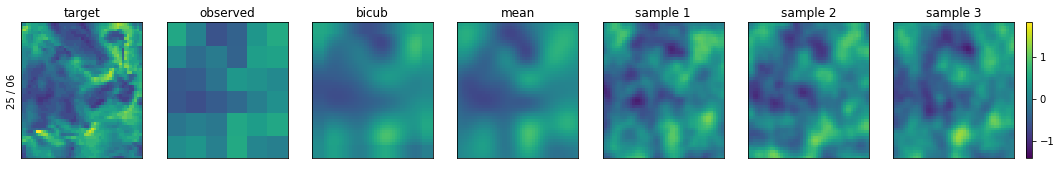

In [105]:
show_fig(np.argmin(compw8), s8)

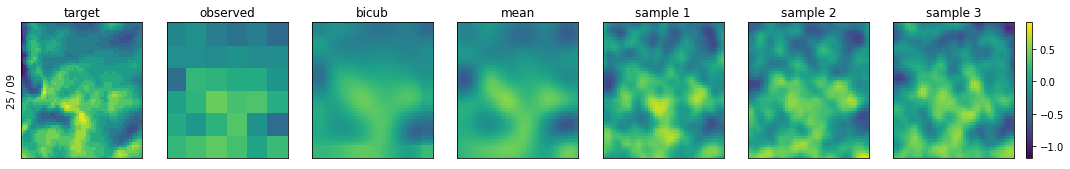

In [106]:
show_fig(np.argsort(compw8)[1], s8)

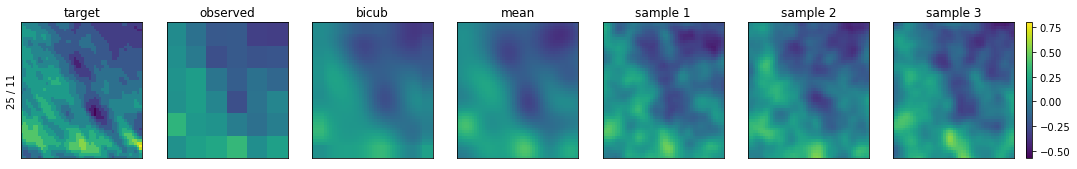

In [107]:
show_fig(np.argsort(compw8)[len(compw)//2], s8)

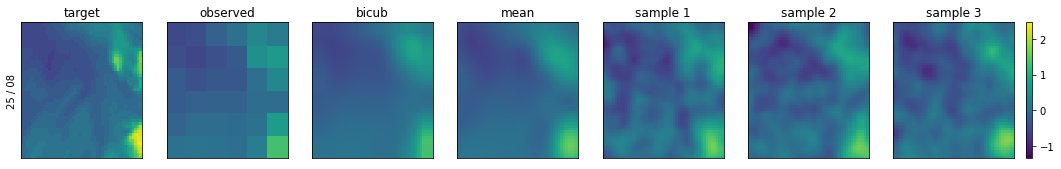

In [108]:
show_fig(np.argsort(compw8)[-1], s8)

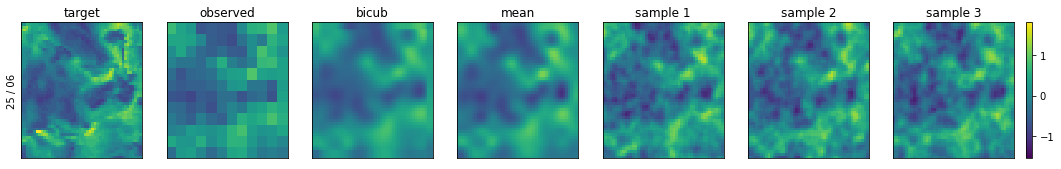

In [109]:
show_fig(np.argmin(compw4), s4)

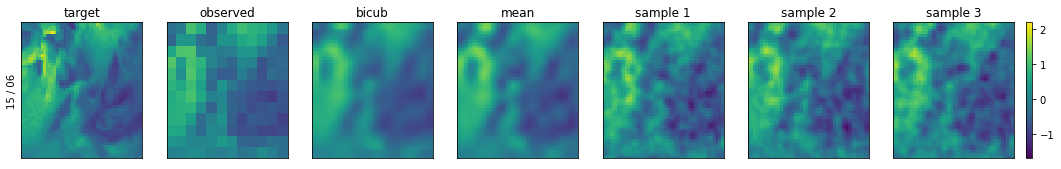

In [110]:
show_fig(np.argsort(compw4)[1], s4)

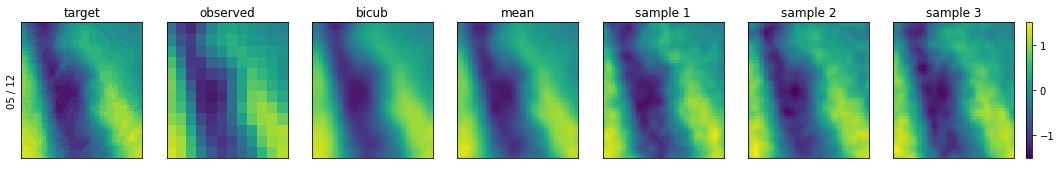

In [111]:
show_fig(np.argsort(compw4)[len(compw)//2], s4)

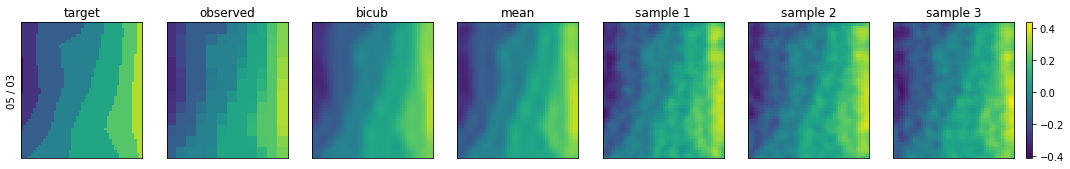

In [112]:
show_fig(np.argsort(compw4)[-1], s4)

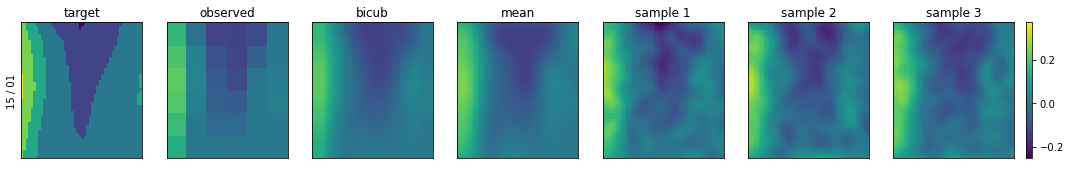

In [113]:
show_fig(np.argsort(compw8)[-2], s8)